# 194.049 Energy-efficient Distributed Systems
## Assignment Part 2: Simulation infrastructure and preliminary implementation
### Gent Rexha (11832486), Princ Mullatahiri (11846033), Ilir Osmanaj (11770999)
#### 27.05.2019

In [42]:
from datetime import datetime
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import pandas as pd
from pathlib import Path
from keras import Sequential
from keras.layers import LSTM, Dense
from matplotlib import pyplot
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error
from plotnine import *

## Preprocessment

In [2]:
data_path = Path('C:/Projects/University/Semester 2 Projects/Energy-efficient Distributed Systems/energy_efficient_ds/Assignment P2/data')
# data_path = Path('../data')

### Data Preparation

In [137]:
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')

df = pd.read_csv(data_path / 'poll.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
df.drop('No', axis=1, inplace=True)

# Manually specify column names
df.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
df.index.name = 'date'

# Mark all NA values with 0
df['pollution'].fillna(0, inplace=True)

# Drop the first 24 hours because all of them have missing values
df = df[24:]

# Summarize first 5 rows
display(df.head())

# Save to file
df.to_csv(data_path / 'pollution.csv')

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [141]:
import random
from copy import deepcopy

# Select only temp and first year for forecast
df_pred = df.loc[:, ['temp']]
df_pred = df_pred.iloc[0:24*7*52]


def create_gap(df):
    """Creates a artificial made gap in the first column of the dataset with a size from 50-100.
    
    Args:
        df (pd.Dataframe): dataframe where the gap should be created
    
    Output:
        dataset (pd.Dataframe): dataframe with random gap
    """
    dataset = deepcopy(df)
    # Leave one month before and at the end so we have enough data to train the model
    gap = random.randint(24*7*4, len(df.index)-24*7*4)
    gap_size = random.randint(50,101)
    dataset.iloc[gap:gap+gap_size] = np.nan
    return dataset


df_gap = create_gap(df_pred)

### Visualizations

#### Dataset without gap

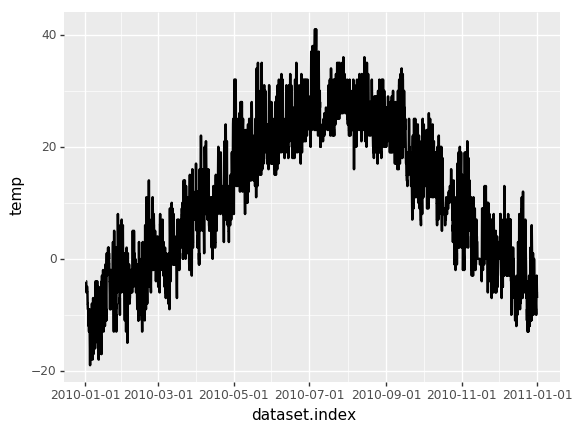

<ggplot: (153105573303)>

In [142]:
dataset = df_pred

(ggplot(dataset, aes('dataset.index', 'temp'))
 + geom_line(size=1))

#### Dataset with gap

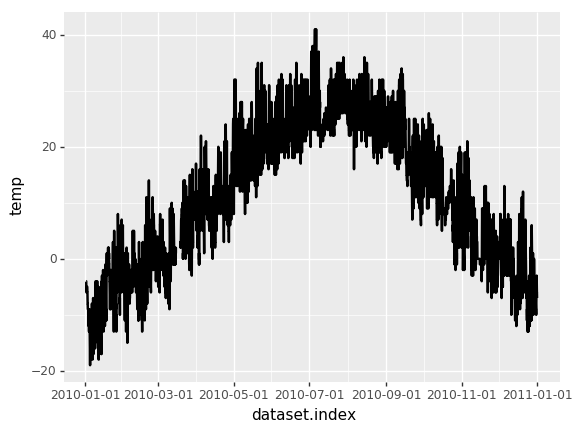

<ggplot: (-9223371883748897427)>

In [143]:
dataset = df_gap

(ggplot(dataset, aes('dataset.index', 'temp'))
 + geom_line(size=1))

### Label Enconding & Scaling

In [4]:
# Load dataset
# dataset = read_csv(data_path / 'pollution.csv', header=0, index_col=0)
values = df.values

# Enconde wnd_dir
le = LabelEncoder()
values[:,4] = le.fit_transform(values[:,4])

# Ensure all data is float
values = values.astype('float32')

# Normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
values = scaler.fit_transform(values)

# Encoded & scaled values
display(values)

array([[0.12977867, 0.35294122, 0.24590163, ..., 0.00229001, 0.        ,
        0.        ],
       [0.14889336, 0.36764708, 0.24590163, ..., 0.00381099, 0.        ,
        0.        ],
       [0.15995975, 0.4264706 , 0.22950819, ..., 0.00533197, 0.        ,
        0.        ],
       ...,
       [0.01006036, 0.2647059 , 0.26229507, ..., 0.41399646, 0.        ,
        0.        ],
       [0.00804829, 0.2647059 , 0.24590163, ..., 0.4208665 , 0.        ,
        0.        ],
       [0.01207243, 0.2794118 , 0.26229507, ..., 0.42621556, 0.        ,
        0.        ]], dtype=float32)

### Transforming Time Series Data into a Supervised Machine Learning Problem

In [5]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """Frame a time series as a supervised learning dataset.
    
    Args:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        pd.Dataframe: The return value. True for success, False otherwise.
    
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols = list()
    names = list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [6]:
# frame as supervised learning
reframed = series_to_supervised(values, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
4   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
5   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-1)  var8(t-1)   var1(t)  
1   0.000000        0.0  0.148893  
2   0.000000        0.0  0.159960  
3   0.000000        0.0  0.182093  
4   0.037037        0.0  0.138833  
5   0.074074        0.0  0.109658  


In [20]:
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
# ilir: change from n_train_hours to -2000
test = values[-2000:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 8) (8760,) (2000, 1, 8) (2000,)


In [9]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
# ilir note: number of epochs was 50 - changed it to 1. Batch size 72 -changed to 1 (because kernel was just dying)
history = model.fit(train_X, train_y, epochs=1, batch_size=1, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# plot history TODO: Fix this plot.
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 8760 samples, validate on 2000 samples
Epoch 1/1
 - 50s - loss: 0.0241 - val_loss: 0.0232


<Figure size 640x480 with 1 Axes>

In [21]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 35.508
